# Description

New version: Don't do logit difference; take logit directly for the cat.

## Load libraries

In [30]:
import vit_prisma

from nltk.corpus import wordnet as wn
from datasets import load_dataset

from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch

import matplotlib.pyplot as plt

# nltk.download('wordnet')

import numpy as np
from fancy_einsum import einsum

from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT

from collections import defaultdict


## Load dataset

We'll load a downsampled subset of ImageNet-1k.

ImageNet-1k's 1000 classes is the closest thing we'll have to a "dictionary" for this notebook. Note that the dictionary is flexible; e.g. if we were using CLIP, we would have a more expansive dictionary than 1000 classes.

(Optional) Technical note on dataset:
Annoyingly the dataset has two labels: the original ImageNet label, and the dataset's own label. We're using a trimmed down version of the ImageNet that only has a subset of classes. For the purposes of this notebook, I'll try to stick with original ImageNet labels and be explicit when using the dataset labels.

In [2]:
# we'll use a subset of imagenet
dataset = load_dataset("zh-plus/tiny-imagenet")

Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/mila/s/sonia.joseph/.cache/huggingface/datasets/zh-plus___tiny-imagenet/default/0.0.0/5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Fri Feb 16 14:14:06 2024).


In [3]:


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])

def transform_batch(examples):
    images = [transform(image) for image in examples['image']]
    labels = torch.tensor(examples['label'])
    return {'image': images, 'label': labels}


# Apply transformations to the dataset
dataset.set_transform(transform_batch)

# Create PyTorch DataLoader
batch_size = 2
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset['valid'], batch_size=batch_size)


### Imagenet helper functions

In [4]:
def map_dataset_idx_to_imagenet_idx(subset_index):
    synset = get_wordnet_synset(subset_index)
    word = get_wordnet_name(synset)[0]
    word = word.replace('_', ' ').lower()
    imagenet_index = imagenet_index_from_word(word)
    return imagenet_index

In [5]:
def get_wordnet_synset(index):
    return dataset['train'].features['label'].names[index]

def get_wordnet_name(synset_id):
    # Make sure you have the wordnet data installed


    # Convert the synset ID to a format NLTK understands (remove 'n' and zero-pad)
    offset = int(synset_id[1:])
    wn_id = f"n{str(offset).zfill(8)}"

    # Look up the synset
    synset = wn.synset_from_pos_and_offset('n', offset)

    # Print out the synset's lemma names (the words associated with this synset)
    names = synset.lemma_names()
    return names

def get_wordnet_name_from_dataset_idx(index):
    synset = get_wordnet_synset(index)
    name = get_wordnet_name(synset)
    return name

def get_index_from_synset(synset):
    return dataset['train'].features['label'].names.index(synset)

In [6]:
import importlib
import vit_prisma
def imagenet_index_from_word(search_term):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        if search_term in value.lower():  # Convert each value to lowercase for case-insensitive comparison
            return key  # Return the key directly once found

    # If the loop completes without returning, the term was not found; raise an exception
    raise ValueError(f"'{search_term}' not found in IMAGENET_DICT.")

def imagenet_indices_from_word(search_term, additional_keywords=None):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Define additional keywords if not provided
    if additional_keywords is None:
        additional_keywords = ['cat', 'feline', 'kitten']

    # Initialize a list to hold all matching keys
    matching_keys = []

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        value_lower = value.lower()
        # Check if the search term is present as a whole word in the value
        if search_term in value_lower.split():
            # Further check against additional keywords to filter out false positives
            for keyword in additional_keywords:
                if keyword in value_lower.split():
                    matching_keys.append(key)
                    break  # Stop checking additional keywords once a match is found

    # Check if any matches were found
    if matching_keys:
        return matching_keys  # Return the list of matching keys
    else:
        # If no matches were found, you could return an empty list or raise an exception
        raise ValueError(f"'{search_term}' not found in IMAGENET_DICT or does not match additional criteria.")


def get_wordnet_synset(index):
    return dataset['train'].features['label'].names[index]



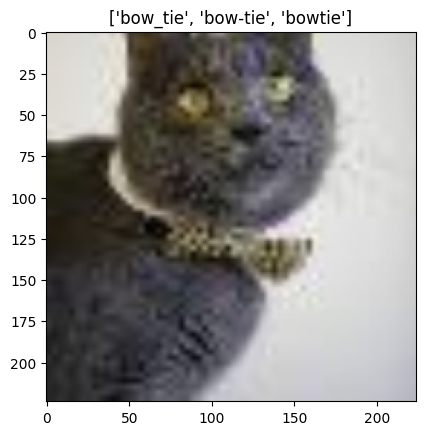

In [7]:
data = next(iter(train_loader))
image, label = data['image'], data['label']

plt.title(get_wordnet_name(get_wordnet_synset(label[1])))
plt.imshow(image[1].permute(1,2,0))



## Load model

In [8]:
# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
prisma_model = HookedViT.from_pretrained("vit_base_patch32_224", 
                                        center_writing_weights=True, 
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


In [9]:

def find_cats(data_loader, cat_label, cat_count=6):
    cat_images = []  # List to store images containing cats
    cat_labels = []  # List to store labels of the images (for verification)

    
    count = 0
    for batch in data_loader:
        images, labels = batch['image'], batch['label']
                
        
        # Find indices of images that are labeled as cats
        cat_indices = [index for index, label in enumerate(labels) if label == cat_label]
        
        # Append the cat images and labels to their respective lists
        for index in cat_indices:
            cat_images.append(images[index])

            # Convert dataset label to imagenet label
            imagenet_label = map_dataset_idx_to_imagenet_idx(labels[index])

            cat_labels.append(imagenet_label)
            count += 1
            
            
            if count >= cat_count:
                break

        
        if count >= cat_count:
            break
    
    return cat_images, cat_labels

# Example usage with the training dataset DataLoader
tabby_syn = 'n02123045'
cat_images_train, cat_labels_train = find_cats(train_loader, cat_label = get_index_from_synset(tabby_syn))

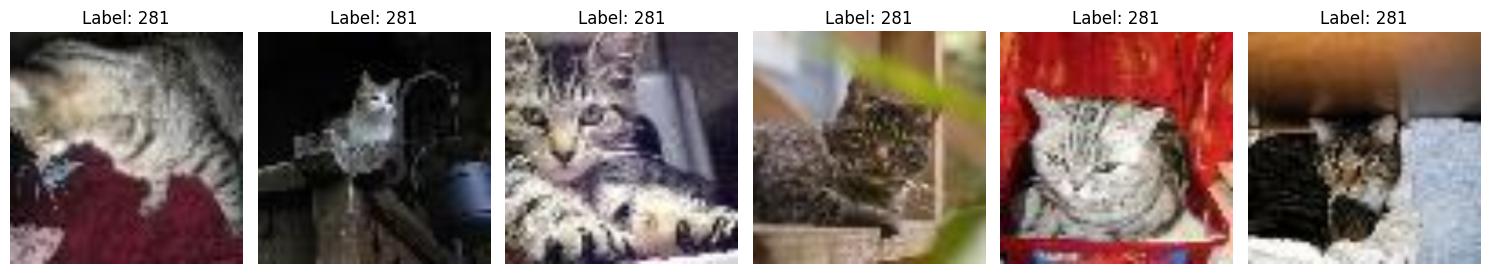

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    """
    Converts a tensor to a PIL image and displays it.
    """
    # Convert the tensor to a PIL image using ToPILImage transform
    to_pil_image = T.ToPILImage()
    img = to_pil_image(tensor)
    plt.imshow(img)
    plt.axis('off')  # Don't show axes for images

# Display the first few cat images
fig = plt.figure(figsize=(15, 6))
for i, tensor in enumerate(cat_images_train[:6], start=1):
    ax = fig.add_subplot(1, 6, i)
    show_image(tensor)
    ax.set_title(f"Label: {cat_labels_train[i-1]}")
plt.tight_layout()
plt.show()

## Inspect logits

### Print logits

Find the logits for tabby cat

In [11]:

def test_prompt(example_prompt, example_answer, model, top_k=10):

    logits = model(example_prompt.unsqueeze(0)) 
    probs = logits.softmax(dim=-1)
    probs = probs.squeeze(0).detach().numpy()
    sorted_probs = np.sort(probs)[::-1]
    sorted_probs_args = np.argsort(probs)[::-1]

    for i in range(top_k):
        index = sorted_probs_args[i]
        prob = sorted_probs[i]
        logit = logits[0, index].item()  # Assuming you want to show the original logit value
        label = IMAGENET_DICT[index]  # Adjust based on your mapping

        rank_str = f"Top {i}th token."
        logit_str = f"Logit: {logit:.2f}"
        prob_str = f"Prob: {prob * 100:.2f}%"
        token_str = f"Label: |{label}|"

        print(f"{rank_str} {logit_str} {prob_str} {token_str}")


    tabby_cat_idx = imagenet_index_from_word(example_answer)
        
    # Example for displaying ranks of the answer tokens, adjust according to your needs
    answer_index = imagenet_index_from_word(example_answer)
    answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
    print("Rank of the correct answer:")
    for ans_index in answer_indices:
        rank = np.where(sorted_probs_args == ans_index)[0][0]
        print(f"Class Name: {example_answer} | Rank: {rank} | ImageNet Index: {tabby_cat_idx}")

example_prompt = cat_images_train[0]
test_prompt(example_prompt, 'tabby cat', prisma_model)


Top 0th token. Logit: 11.51 Prob: 71.76% Label: |Egyptian cat|
Top 1th token. Logit: 9.91 Prob: 14.46% Label: |tabby, tabby cat|
Top 2th token. Logit: 9.40 Prob: 8.67% Label: |tiger cat|
Top 3th token. Logit: 6.61 Prob: 0.54% Label: |nipple|
Top 4th token. Logit: 5.88 Prob: 0.26% Label: |lynx, catamount|
Top 5th token. Logit: 5.72 Prob: 0.22% Label: |plastic bag|
Top 6th token. Logit: 5.53 Prob: 0.18% Label: |loupe, jeweler's loupe|
Top 7th token. Logit: 4.86 Prob: 0.09% Label: |bluetick|
Top 8th token. Logit: 4.86 Prob: 0.09% Label: |cassette player|
Top 9th token. Logit: 4.86 Prob: 0.09% Label: |space heater|
Rank of the correct answer:
Class Name: tabby cat | Rank: 1 | ImageNet Index: 281


### Get Logit difference

Things get a bit tricky here. Between tabby cat and non-cat? Between all classes of cats (tabby cats, tiger cats, Egyptian cats, and Persian cats), and non-cats? What about big cats like lynxes and polecats and lions?

A more principled way would be to set a neighborhood of points around the tabby_cat embedding in semantic space and create a tabby cat l-norm ball. However, this is a pending research topic and out of scope for the current demo. So we'll just do tabby cat vs non-tabby cat for now. In the future, we may cluster all the cats together for predictions that are more coarse-grained.

For the non-cat, we'll pick random non-cat objects. We'll avoid cat-like classes for cleanness. This is not necessarily the most principled way of picking a non-cat point in semantic space but good enough for our current purposes.

In [12]:
# Run model and cache activations
cat_images = torch.stack(cat_images_train)
original_logits, cache = prisma_model.run_with_cache(cat_images)

original_logits.shape

torch.Size([6, 1000])

In [13]:
for i, l in zip(cat_images_train, cat_labels_train):
    word_label = IMAGENET_DICT[l]
    test_prompt(i, word_label, prisma_model)
    print('\n')

Top 0th token. Logit: 11.51 Prob: 71.76% Label: |Egyptian cat|
Top 1th token. Logit: 9.91 Prob: 14.46% Label: |tabby, tabby cat|
Top 2th token. Logit: 9.40 Prob: 8.67% Label: |tiger cat|
Top 3th token. Logit: 6.61 Prob: 0.54% Label: |nipple|
Top 4th token. Logit: 5.88 Prob: 0.26% Label: |lynx, catamount|
Top 5th token. Logit: 5.72 Prob: 0.22% Label: |plastic bag|
Top 6th token. Logit: 5.53 Prob: 0.18% Label: |loupe, jeweler's loupe|
Top 7th token. Logit: 4.86 Prob: 0.09% Label: |bluetick|
Top 8th token. Logit: 4.86 Prob: 0.09% Label: |cassette player|
Top 9th token. Logit: 4.86 Prob: 0.09% Label: |space heater|
Rank of the correct answer:
Class Name: tabby, tabby cat | Rank: 1 | ImageNet Index: 281


Top 0th token. Logit: 10.21 Prob: 66.46% Label: |milk can|
Top 1th token. Logit: 7.20 Prob: 3.30% Label: |fox squirrel, eastern fox squirrel, Sciurus niger|
Top 2th token. Logit: 6.99 Prob: 2.67% Label: |grey fox, gray fox, Urocyon cinereoargenteus|
Top 3th token. Logit: 6.89 Prob: 2.42% L

I'm thinking randomly picking images doesn't make sense, can actually plot out numbers in semantic space.

Instead, you can create a manifold

You can use the manifold to approximate the semantic space of the net

In [14]:

cat_labels = torch.Tensor(cat_labels_train).long().unsqueeze(0).T
answer_logits = original_logits.gather(dim=-1, index=cat_labels)

average_answer = answer_logits.mean()
print(answer_logits)
print(answer_logits.mean())

tensor([[ 9.9072],
        [ 5.1827],
        [10.5455],
        [ 9.1463],
        [ 8.3945],
        [ 7.3279]], grad_fn=<GatherBackward0>)
tensor(8.4174, grad_fn=<MeanBackward0>)


## Direct logit attribution

In [15]:
answer_residual_directions = prisma_model.tokens_to_residual_directions(cat_labels_train)
print(answer_residual_directions.shape)

torch.Size([6, 768])


In [16]:
final_residual_stream = cache["resid_post", -1]

# Put 0 to get CLS token at beginning
cls_token_residual_stream = final_residual_stream[:, 0, :]

scaled_final_token_residual_stream = cache.apply_ln_to_stack(cls_token_residual_stream, layer=-1, pos_slice=0 )


average_logit = einsum(
    "batch d_model, batch d_model -> batch",
    scaled_final_token_residual_stream,
    answer_residual_directions,
)


average_logit = average_logit + prisma_model.head.b_H[cat_labels][:,0] 
average_logit = average_logit.mean()


print("Calculated average logit diff:", round(average_logit.item(), 3))
print("Original logit difference:", round(average_answer.item(), 3))

Calculated average logit diff: 8.417
Original logit difference: 8.417


## Logit lens

In [17]:
import plotly.express as px

def line(array, **kwargs):
    px.line(
        y=array.detach().cpu().numpy(),
        **kwargs,
    ).show()

In [18]:

def residual_stack_to_logit(
    residual_stack,
    cache
):

    scaled_residual_stack = cache.apply_ln_to_stack(
            accumulated_residual, layer=-1, pos_slice=0
        )


    logit_predictions = einsum(
        "layer batch d_model, batch d_model -> batch layer",
        scaled_residual_stack,
        answer_residual_directions,
    )
    return logit_predictions


accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=0, return_labels=True
        
    )
logit_predictions = residual_stack_to_logit(accumulated_residual, cache)

print(logit_predictions.shape)
logit_predictions = logit_predictions.T + prisma_model.head.b_H[cat_labels][:,0] # Add bias to ensure matching results above
average_logit = logit_predictions.mean(-1).T

line(average_logit, labels=labels, hover_name=labels, title="Logits through residual stream")

torch.Size([6, 25])


/tmp/ipykernel_614472/2268541660.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  average_logit = logit_predictions.mean(-1).T


## Patch logit lens

In [34]:

def get_patch_logit_directions(cache):
    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True
    )
    scaled_residual_stack = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,
    )
    all_answers = prisma_model.tokens_to_residual_directions(np.arange(1000))

    result = torch.einsum('lbpd,od -> lbpo', scaled_residual_stack, all_answers)
    # Rearrange so batches are first
    result = result.permute(1, 2, 0, 3)
    return result

def get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=None):
    patch_dictionary = defaultdict(list)
    # Go through laeyrs of one batch
    patch_info = np.array((patch_logit_directions.shape[1], patch_logit_directions.shape[2])) # logit, class_name
    for patch_idx, patches in enumerate(patch_logit_directions[batch_idx]):
        # Go through every patch and get max prediction
        for logits in patches:        
            probs = torch.softmax(logits, dim=-1)
            # Get index of max prediction
            idx = int(torch.argmax(probs))
            logit = logits[idx].item()
            class_name = IMAGENET_DICT[idx]
            if rank_label:
                # Where is the rank_label in the sorted list?
                imagenet_index = imagenet_index_from_word(rank_label)
                sorted_list = torch.argsort(probs, descending=True)
                rank = np.where(sorted_list == imagenet_index)[0][0]
                patch_dictionary[patch_idx].append((logit, class_name, rank))
            else:
                patch_dictionary[patch_idx].append((logit, class_name))
    return patch_dictionary


In [26]:
import plotly.graph_objs as go
import numpy as np

import re  # Import the regular expressions library

def display_patch_logit_lens(patch_dictionary):

    # Keywords to identify cat-related entries, prepared as a regex pattern for whole words
    cat_keywords = ['cat', 'lynx', 'leopard', 'cougar', 'puma', 'lion', 'tiger', 'panther']
    cat_pattern = r'\b(' + '|'.join(cat_keywords) + r')\b'

    # Assuming patch_dictionary is already defined and structured as before

    # Simulate patch_dictionary for demonstration
    # patch_dictionary = {i: [(np.random.random(), f'label_{j}') for j in range(25)] for i in range(50)}

    # Extracting numeric values for heatmap
    data_array_formatted = np.array([[item[0] for item in list(patch_dictionary.values())[i]] for i in range(50)])

    # Extracting labels for hover text
    hover_text = [[str(i) + " " + item[1] for item in list(patch_dictionary.values())[i]] for i in range(50)]

    # Creating the interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=data_array_formatted,
        x=list(patch_dictionary.keys()),
        y=[f'Patch {i}' for i in range(data_array_formatted.shape[0])],
        hoverongaps=False,
        colorbar=dict(title='Values'),
        text=hover_text,
        hoverinfo="text"
    ))


    # Initialize a list to hold annotations
    annotations = []

    # Calculate half the distance between cells in both x and y directions
    x_half_dist = 0.5
    y_half_dist = 0.2

    # Check each hover text for the word "cat" and add a star annotation if found
    for i, row in enumerate(hover_text):
        for j, text in enumerate(row):
            if re.search(cat_pattern, text, re.IGNORECASE):
                # Adjust x and y positions for center alignment by adding half distance
                annotations.append(go.layout.Annotation(x=j + x_half_dist, y=i + y_half_dist, text="★", showarrow=False, font=dict(color="white", size=7)))
    # Add annotations to the figure
    fig.update_layout(annotations=annotations)

    fig.update_layout(
        title='Per-Patch Logit Lens',
        xaxis=dict(title='Layer Number'),
        yaxis=dict(title='Patch Number'),
        # autosize=False,
        width=1000,
        height=600
    )

    fig.show()


In [ ]:

from collections import defaultdict

def residual_stack_to_logit_diff(
    residual_stack,
    cache,
    pos_slice
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=pos_slice
    )

    # # print shapes
    # print(scaled_residual_stack.shape)
    # print(answer_residual_directions.shape)

    result = torch.einsum('ijk,lk->ijl', scaled_residual_stack, all_answers)
    return result

def patch_logit_lens(cache):

    patch_ranks = np.empty((50, 25))
    patch_logits = np.empty((50, 25))
    patch_dictionary = defaultdict(list)

    for pos_slice in range(50):
        patch_info = []

        accumulated_residual, labels = cache.accumulated_resid(
            layer=-1, incl_mid=True, pos_slice=pos_slice, return_labels=True
        )

        predictions = residual_stack_to_logit_diff(accumulated_residual, cache, pos_slice=pos_slice)
        print(predictions.shape)

        top_k = 5
        batch_idx = 1

        rank_list = []
        top_of_multiple = []
        for layer_idx, logits in enumerate(predictions[:,batch_idx,:]):

            probs = logits.softmax(dim=-1)
            probs = probs.squeeze(0).detach().numpy()
            sorted_probs = np.sort(probs)[::-1]
            sorted_probs_args = np.argsort(probs)[::-1]

            print("Layer", layer_idx)
            for i in range(top_k):
                index = sorted_probs_args[i]
                prob = sorted_probs[i]
                logit = logits[index].item()  # Assuming you want to show the original logit value
                label = IMAGENET_DICT[index]  # Adjust based on your mapping

                logit_str = f"Logit: {logit:.2f}"
                prob_str = f"Prob: {prob * 100:.2f}%"
                token_str = f"Label: |{label}|"

                # print(f"{rank_str} {logit_str} {prob_str} {token_str}")
                if i == 0:
                    patch_dictionary[pos_slice].append((logit, label))
            

            answer_index = imagenet_index_from_word("tabby cat")
            answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
            # print("Rank of the correct answer:")
            for ans_index in answer_indices:
                rank = np.where(sorted_probs_args == ans_index)[0][0]
                logit = logits[ans_index].item()
            
            print(f"Class Name: {'tabby cat'} | Rank: {rank} | ImageNet Index: {answer_index}")
            rank_list.append(rank)

            patch_ranks[pos_slice, layer_idx] = rank
    return patch_ranks




In [27]:
import plotly.graph_objs as go
import numpy as np

import re  # Import the regular expressions library


import matplotlib.pyplot as plt
from PIL import Image


# Assuming image is a 224x224x3 NumPy array

import numpy as np
import matplotlib.pyplot as plt

def divide_image_into_patches(image_array, patch_size=(32, 32)):
    """
    Divides a given image array of shape (224, 224, 3) into patches of specified size.
    
    Parameters:
    - image_array: Numpy array of shape (224, 224, 3).
    - patch_size: Tuple indicating the size of each patch (height, width).
    
    Returns:
    - A list of patches, each patch is a Numpy array of shape (patch_size[0], patch_size[1], 3).
    """
    patches = []
    
    # Calculate the number of patches in both dimensions
    num_patches_x = image_array.shape[1] // patch_size[1]
    num_patches_y = image_array.shape[0] // patch_size[0]
    
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Define the start and end indices for y and x dimensions
            start_y = i * patch_size[0]
            end_y = start_y + patch_size[0]
            start_x = j * patch_size[1]
            end_x = start_x + patch_size[1]
            
            # Extract the patch using array slicing and append it to the list of patches
            patch = image_array[start_y:end_y, start_x:end_x, :]
            patches.append(patch)
    
    return patches

# Example usage with a numpy array representing an image of shape 224x224x3
# Assuming `image_array` is your input numpy array
# image



def display_grid_on_image(image, patch_size=32):

    image = image.detach().numpy().transpose(1,2,0)

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    num_patches = (image.shape[0] / patch_size) ** 2

    grid_size = int(np.sqrt(num_patches))

    # Calculate patch size
    patch_height = image.shape[0] // grid_size
    patch_width = image.shape[1] // grid_size

    # Overlay grida
    grid_image = np.copy(image)
    for i in range(1, grid_size):
        # Vertical lines
        grid_image[:, patch_width * i, :] = [255, 255, 255]
        # Horizontal lines
        grid_image[patch_height * i, :, :] = [255, 255, 255]

    plt.figure(figsize=(4, 4), dpi=100)  # Adjust figsize and dpi as needed

    # Place labels
    for i in range(grid_size):
        for j in range(grid_size):
            x_center = (j * patch_width) + (patch_width // 2)
            y_center = (i * patch_height) + (patch_height // 2)
            # Convert the patch index to 2D coordinates (row, column)
            patch_index = i * grid_size + j
            row, col = divmod(patch_index, grid_size)
            plt.text(x_center, y_center, f"{patch_index+1}", color='red', fontsize=8, ha='center', va='center')

    # Display image with grid and labels
    # plt.figure(figsize=(8, 8))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.show()




In [36]:
patch_logit_directions = get_patch_logit_directions(cache)


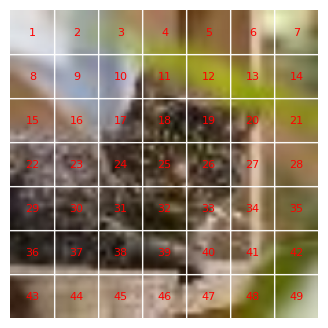

In [37]:
 
batch_idx = 3
image = cat_images[batch_idx]
patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=batch_idx, rank_label='tabby cat')

display_patch_logit_lens(patch_dictionary)
display_grid_on_image(image)



In [38]:
import plotly.graph_objects as go
import numpy as np

rank_formatted = np.array([[item[2] for item in list(patch_dictionary.values())[i]] for i in range(50)])

traces = []
# Adjusted line color and width using one-liner if-else condition and all data points refer to the same data
for i, patch_data in enumerate(rank_formatted):
    color, width = ('rgba(0, 0, 255, 1.0)', 2) if i == 0 else ('rgba(128, 128, 128, 0.5)', 1)
    trace = go.Scatter(
        x=list(range(1, 51)),
        y=patch_data,
        mode='lines+markers' if i == 0 else 'lines',
        line=dict(color=color, width=width),
        hoverinfo='text',
        text=[f'Layer {x} - {"CLS Token - " if i == 0 else "Patch " + str(i) + " - "} Rank {y}' for x, y in enumerate(patch_data)],
        # For visual distinction, maintaining all on the same axis in this setup.
    )
    traces.append(trace)

fig = go.Figure(traces)

fig.update_layout(
    title='Patch Ranks Over Layers',
    xaxis_title='Layer',
    yaxis_title='Rank',
    # yaxis_type='log',
    hovermode='closest',
    showlegend=False,  # Omit the global legend as we're seeking a hover-based focus
)

# Chart layout with an extra y-axis
fig.update_layout(
    title='Patch/CLS Logit Differentiation per Layers',
    xaxis_title='Layer',
    yaxis=dict(
        title='Rank',
    ),
    yaxis2=dict(
        title='Logit Adjustment',
        overlaying='y',  # Sits atop the first y-axis for x-axis data marrying
        side='right',
        titlefont=dict(color='rgba(255, 0, 0, 0.5)'),
        tickfont=dict(color='rgba(255, 0, 0, 0.5)'),
    ),
    hovermode='closest',
)


fig.show()


In [71]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# # Reload modules
# import importlib
# importlib.reload(plotly.subplots)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# Assuming rank_list and logit_lens_logit_diffs are defined
# Convert logit_lens_logit_diffs to a NumPy array if it's a torch tensor
cls_token = patch_logit_directions[0][:,0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add rank plot
fig.add_trace(
    go.Scatter(x=list(range(len(cls_token))), y=cls_token, name="Rank of tabby cat", mode='lines+markers'),
    secondary_y=False,
)

# Add top of multiple
fig.add_trace(
    go.Scatter(x=list(range(len(top_of_multiple))), y=top_of_multiple, name="Rank of cat", mode='lines+markers'),
    secondary_y=False,
)

# Add logit difference plot
fig.add_trace(
    go.Scatter(x=list(range(len(average_logit))), y=logit_diffs_np, name="Logit diff", mode='lines+markers'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Rank of Tabby Cat and Logit Differences Through Model Layers"
)

# Set x-axis title
fig.update_xaxes(title_text="Model Layers")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Rank</b> of tabby cat", secondary_y=False)
fig.update_yaxes(title_text="<b>Logit Difference</b>", secondary_y=True)

fig.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## Layer attribution

In [39]:
def residual_stack_to_logit_layer(
    residual_stack,
    cache
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        answer_residual_directions,
    ) / len(cat_images)

per_layer_residual, labels = cache.decompose_resid(
    layer=-1, pos_slice=0, return_labels=True
)

print(per_layer_residual.shape)

per_layer_logit_diffs = residual_stack_to_logit_layer(per_layer_residual.detach().numpy(), cache)
# line(per_layer_logit_diffs)

torch.Size([26, 6, 768])


TypeError: _mean() got an unexpected keyword argument 'dim'

## Head attribution

In [ ]:
def residual_stack_to_logit_attn(
    residual_stack,
    cache
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        answer_residual_directions,
    ) / len(cat_images)

In [ ]:
import einops
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=0, return_labels=True
)

per_head_logit_diffs = residual_stack_to_logit_attn(per_head_residual, cache)

per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=prisma_model.cfg.n_layers,
    head_index=prisma_model.cfg.n_heads,
)
px.imshow(
    per_head_logit_diffs.detach().cpu().numpy(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

Tried to stack head results when they weren't cached. Computing head results now


## Attention analysis

Empirically, the attention scores are more interpretable than the attention patterns (unlike language, where patterns tend to be visualized). We'll focus on visualizing the attention scores.

In [ ]:
def visualize_attention_patterns(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []


    for head in heads:
        # Set the label
        layer = head // prisma_model.cfg.n_heads
        head_index = head % prisma_model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_idx, head_index])

    # # Convert the tokens to strings (for the axis labels)
    # str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    print(patterns.shape)
    return patterns

def visualize_attention_scores(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []


    for head in heads:
        # Set the label
        layer = head // prisma_model.cfg.n_heads
        head_index = head % prisma_model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn_scores", layer][batch_idx, head_index])

    # # Convert the tokens to strings (for the axis labels)
    # str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    print(patterns.shape)
    return patterns

In [ ]:
top_k = 3
top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

print(top_positive_logit_attr_heads)

batch_idx = 0
patterns = visualize_attention_patterns(top_positive_logit_attr_heads, cache, "test", 700, batch_idx = batch_idx)


tensor([136, 137, 143])
torch.Size([3, 50, 50])


In [ ]:
list_of_images = [cat_images[batch_idx], cat_images[batch_idx], cat_images[batch_idx]]

print(len(patterns))
print

3


<function print>

In [ ]:
import importlib

# First, ensure you have imported the module at least once
import vit_prisma.visualization.visualize_attention_js

# Reload the module
importlib.reload(vit_prisma.visualization.visualize_attention_js)

# Now, import the specific function you need
from vit_prisma.visualization.visualize_attention_js import plot_javascript


In [ ]:
from vit_prisma.visualization.visualize_attention_js import plot_javascript
patterns = visualize_attention_patterns(top_positive_logit_attr_heads, cache, "test", 700, batch_idx = batch_idx)

html_code = plot_javascript(patterns, list_of_images, ATTN_SCALING=8)

# import
from IPython.display import HTML, display


display(HTML(html_code))

torch.Size([3, 50, 50])


In [ ]:
# import
from IPython.display import HTML, display
patterns = visualize_attention_scores(top_positive_logit_attr_heads, cache, "test", 700, batch_idx = batch_idx)

html_code = plot_javascript(patterns, list_of_images, ATTN_SCALING=8)

display(HTML(html_code))

torch.Size([3, 50, 50])


Is the 44th patch token also a register token? This is also the 44 idx (includign CLS token).

We should ablate the 44th token and see the effect on logits. Or we could just feed all the tokens into the logit head for tabby cats and see which has the highest logit score.

## Activation patching

Maybe I can activation patch with the ear?

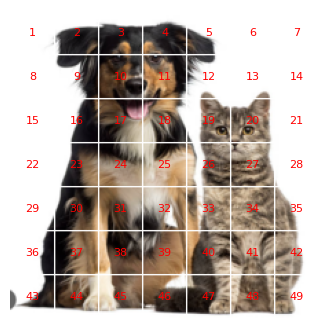

In [78]:
# Load cat.png image

# Load the image
from PIL import Image
image = Image.open("cat.png")

# Turn into tensor

image = transform(image)
# print(image.shape)
# plt.figure()
# plt.imshow(image.permute(0,2,3,1).squeeze(0))

# show as grid
display_grid_on_image(image)

In [81]:
image.shape

torch.Size([3, 224, 224])

In [82]:
# Patch logit lens
output, cache = prisma_model.run_with_cache(image.unsqueeze(0))

In [83]:
patch_logit_directions = get_patch_logit_directions(cache)


In [94]:
import plotly.graph_objs as go
import numpy as np

import re  # Import the regular expressions library

def display_patch_logit_lens_cat_dog(patch_dictionary):

    # Keywords to identify cat-related entries, prepared as a regex pattern for whole words
    cat_keywords = ['cat', 'lynx', 'leopard', 'cougar', 'puma', 'lion', 'tiger', 'panther', 'cheetah']
    cat_pattern = r'\b(' + '|'.join(cat_keywords) + r')\b'

    dog_keywords = [
    'Chihuahua',
    'Japanese spaniel',
    'Maltese dog, Maltese terrier, Maltese',
    'Pekinese, Pekingese, Peke',
    'Shih-Tzu',
    'Blenheim spaniel',
    'papillon',
    'toy terrier',
    'Rhodesian ridgeback',
    'Afghan hound, Afghan',
    'basset, basset hound',
    'beagle',
    'bloodhound, sleuthhound',
    'bluetick',
    'black-and-tan coonhound',
    'Walker hound, Walker foxhound',
    'English foxhound',
    'redbone',
    'borzoi, Russian wolfhound',
    'Irish wolfhound',
    'Italian greyhound',
    'whippet',
    'Ibizan hound, Ibizan Podenco',
    'Norwegian elkhound, elkhound',
    'otterhound, otter hound',
    'Saluki, gazelle hound',
    'Scottish deerhound, deerhound',
    'Weimaraner',
    'Staffordshire bullterrier, Staffordshire bull terrier',
    'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
    'Bedlington terrier',
    'Border terrier',
    'Kerry blue terrier',
    'Irish terrier',
    'Norfolk terrier',
    'Norwich terrier',
    'Yorkshire terrier',
    'wire-haired fox terrier',
    'Lakeland terrier',
    'Sealyham terrier, Sealyham',
    'Airedale, Airedale terrier',
    'cairn, cairn terrier',
    'Australian terrier',
    'Dandie Dinmont, Dandie Dinmont terrier',
    'Boston bull, Boston terrier',
    'miniature schnauzer',
    'giant schnauzer',
    'standard schnauzer',
    'Scotch terrier, Scottish terrier, Scottie',
    'Tibetan terrier, chrysanthemum dog',
    'silky terrier, Sydney silky',
    'soft-coated wheaten terrier',
    'West Highland white terrier',
    'Lhasa, Lhasa apso',
    'flat-coated retriever',
    'curly-coated retriever',
    'golden retriever',
    'Labrador retriever',
    'Chesapeake Bay retriever',
    'German short-haired pointer',
    'vizsla, Hungarian pointer',
    'English setter',
    'Irish setter, red setter',
    'Gordon setter',
    'Brittany spaniel',
    'clumber, clumber spaniel',
    'English springer, English springer spaniel',
    'Welsh springer spaniel',
    'cocker spaniel, English cocker spaniel, cocker',
    'Sussex spaniel',
    'Irish water spaniel',
    'kuvasz',
    'schipperke',
    'groenendael',
    'malinois',
    'briard',
    'kelpie',
    'komondor',
    'Old English sheepdog, bobtail',
    'Shetland sheepdog, Shetland sheep dog, Shetland',
    'collie',
    'Border collie',
    'Bouvier des Flandres, Bouviers des Flandres',
    'Rottweiler',
    'German shepherd, German shepherd dog, German police dog, alsatian',
    'Doberman, Doberman pinscher',
    'miniature pinscher',
    'Greater Swiss Mountain dog',
    'Bernese mountain dog',
    'Appenzeller',
    'EntleBucher',
    'boxer',
    'bull mastiff',
    'Tibetan mastiff',
    'French bulldog',
    'Great Dane',
    'Saint Bernard, St Bernard',
    'Eskimo dog, husky',
    'malamute, malemute, Alaskan malamute',
    'Siberian husky',
    'dalmatian, coach dog, carriage dog',
    'affenpinscher, monkey pinscher, monkey dog',
    'basenji',
    'pug, pug-dog',
    'Leonberg',
    'Newfoundland, Newfoundland dog',
    'Great Pyrenees',
    'Samoyed, Samoyede',
    'Pomeranian',
    'chow, chow chow',
    'keeshond',
    'Brabancon griffon',
    'Pembroke, Pembroke Welsh corgi',
    'Cardigan, Cardigan Welsh corgi',
    'toy poodle',
    'miniature poodle',
    'standard poodle',
    'Mexican hairless',
    'timber wolf, grey wolf, gray wolf, Canis lupus',
    'white wolf, Arctic wolf, Canis lupus tundrarum',
    'red wolf, maned wolf, Canis rufus, Canis niger',
    'coyote, prairie wolf, brush wolf, Canis latrans',
    'dingo, warrigal, warragal, Canis dingo',
    'dhole, Cuon alpinus',
    'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
    'hyena, hyaena',
    'red fox, Vulpes vulpes',
    'kit fox, Vulpes macrotis',
    'Arctic fox, white fox, Alopex lagopus',
    'grey fox, gray fox, Urocyon cinereoargenteus'
    ]
    
    
    dog_pattern = r'\b(' + '|'.join(dog_keywords) + r')\b'

    # Assuming patch_dictionary is already defined and structured as before

    # Simulate patch_dictionary for demonstration
    # patch_dictionary = {i: [(np.random.random(), f'label_{j}') for j in range(25)] for i in range(50)}

    # Extracting numeric values for heatmap
    data_array_formatted = np.array([[item[0] for item in list(patch_dictionary.values())[i]] for i in range(50)])

    # Extracting labels for hover text
    hover_text = [[str(i) + " " + item[1] for item in list(patch_dictionary.values())[i]] for i in range(50)]

    # Creating the interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=data_array_formatted,
        x=list(patch_dictionary.keys()),
        y=[f'Patch {i}' for i in range(data_array_formatted.shape[0])],
        hoverongaps=False,
        colorbar=dict(title='Values'),
        text=hover_text,
        hoverinfo="text"
    ))


    # Initialize a list to hold annotations
    annotations = []

    # Calculate half the distance between cells in both x and y directions
    x_half_dist = 0.5
    y_half_dist = 0.2

    for i, row in enumerate(hover_text):
        for j, text in enumerate(row):
            cat_match = re.search(cat_pattern, text, re.IGNORECASE)
            dog_match = re.search(dog_pattern, text, re.IGNORECASE)
            
            x_position = j + x_half_dist
            y_position = i + y_half_dist

            # For the dog—🐾, and let's continue with ★ for the cats
            if cat_match:
                annotations.append(go.layout.Annotation(x=x_position, y=y_position, text="★", showarrow=False, font=dict(color="red", size=7)))
            elif dog_match:
                annotations.append(go.layout.Annotation(x=x_position, y=y_position, text="🐾", showarrow=False, font=dict(color="blue", size=7)))

        # Integrate annotations; finalize hover-text with each exec
    fig.update_layout(annotations=annotations)
        


In [95]:
# patch logit lens
patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label='tabby cat')
display_patch_logit_lens_cat_dog(patch_dictionary)


## Residual stream

## Layers

## Heads

## Decomposing heads

## Consolidating understanding

## Random fun things